# SUPERMARKET SALES

Proyecto de análisis de Series Temporales y Forecast
-- EDA --

Jose Luis Quintero García, abr2023

## Importación de librerías y carga de datos

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
ordenes = pd.read_csv("./ordenes.csv", parse_dates=["Order Date", "Ship Date"])
ordenes.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales,Quantity,Discount,Profit,Devolucion
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-BO-10001798,261.9600,2,0.00,41.9136,0
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-CH-10000454,731.9400,3,0.00,219.5820,0
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,OFF-LA-10000240,14.6200,2,0.00,6.8714,0
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,FUR-TA-10000577,957.5775,5,0.45,-383.0310,0
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,OFF-ST-10000760,22.3680,2,0.20,2.5164,0


## EDA

### Transformaciones previas

Para el análisis inicial agruparemos todas las ventas por fecha, sumando valores numéricos. Aquí no nos importan los datos categóricos. Usaremos la fecha de pedido (Order Date) y hay que tener en cuenta que los pedidos devueltos no deben sumar.

Además, los datos diarios para una serie de tanto tiempo posiblemente sea una frecuencia excesiva. Agruparemos los datos por ventas mensuales (perderemos la variable categórica de Ship Mode y la fecha de embarque, pero no usaremos estas variables en nuestro análisis, así que no nos importa demasiado).

In [55]:
# Quitamos los registros donde haya una devolución
ordenes = ordenes.loc[ordenes["Devolucion"]==0]

# Borramos la columna "devolucion", que ahora sobra
ordenes.drop(["Devolucion"], axis=1, inplace=True)

In [56]:
# Agrupamos por fechas
ordenes_totales = ordenes.groupby(ordenes["Order Date"]).sum()
ordenes_totales.head()

C:\Users\josel\AppData\Local\Temp\ipykernel_4176\3044568036.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ordenes_totales = ordenes.groupby(ordenes["Order Date"]).sum()


,Sales,Quantity,Discount,Profit
Order Date,,,,
2014-01-03,16.448,2,0.2,5.5512
2014-01-04,288.060,8,1.2,-65.9901
2014-01-05,19.536,3,0.2,4.8840
2014-01-06,4407.100,30,0.0,1358.0524
2014-01-07,87.158,10,1.4,-71.9621


In [57]:
# Cambiamos la frecuencia a datos mensuales
ordenes_mensuales = ordenes_totales.resample("M").ffill()   # El valor "M" nos agrupa valores a final del mes
ordenes_mensuales = ordenes_mensuales.fillna(0)
ordenes_mensuales.head()

,Sales,Quantity,Discount,Profit
Order Date,,,,
2014-01-31,290.666,2,0.15,3.4196
2014-02-28,19.456,4,0.20,3.4048
2014-03-31,1959.552,29,3.70,355.1097
2014-04-30,1048.740,13,0.00,276.4956
2014-05-31,773.700,6,0.00,230.9727


In [58]:
ordenes_mensuales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-31 to 2017-12-31
Freq: M
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sales     48 non-null     float64
 1   Quantity  48 non-null     int64  
 2   Discount  48 non-null     float64
 3   Profit    48 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 1.9 KB


Del dataset original con todos los datos, excepto Order ID, las fechas y Ship Mode, las demás variables son numéricas.

La variable Order ID no nos interesa mucho, dado que es solo la clave del pedido y, en este momento, no nos interesa para nada.

La variable categórica Ship Mode nos indica la forma en la que se sirve el pedido. No la usaremos en este análisis, aunque tiene un interesante valor desde el punto de vista logístico. Ver lo descrito más adelante con Ship Date.

Sobre las fechas, hay dos:

- Order Date, será la fecha en la que se emite el pedido y la que utilizaremos para el análisis econópmico.
- Ship Date, la decha en la que se sirve el pedido. Esta fecha puede ser intertesante para un análisis logístico (retraso medio de pedidos, correlación con productos o tiendas, influencia en la rentabilidad, influencia entre retrasos y devolución de pedidos, etc.). Aquí no la usaremos, dado que las preguntas que nos vamos a hacer tienen un caracter relacionado con las ventas, no logístico, pero podría suponer un área ndiferente y muy interesante de estudio.

Veamos el ámbito en el que se mueven esas fechas, volviendo al dataset donde hemos agrupado los datos por meses.

In [59]:
print(f"Fecha mínima: {ordenes_mensuales.index.min()}; Fecha máxima: {ordenes_mensuales.index.max()}")

Fecha mínima: 2014-01-31 00:00:00; Fecha máxima: 2017-12-31 00:00:00


Es decir, el dataset nos muestra valores mensuales desde enero de 2014 a diciembre de 2017.

Pasemos a analizar ahora las variables numéricas.

In [60]:
for columna in ordenes_mensuales.columns:
    print(f" Valor mínimo de {columna}: {ordenes_mensuales[columna].min()}")
    print(f" Valor máximo de {columna}: {ordenes_mensuales[columna].max()}")
    print(f" Valor medio de {columna}: {ordenes_mensuales[columna].mean()}")
    print(f" Desviación típica de {columna}: {ordenes_mensuales[columna].std()}")
    print("-----")

 Valor mínimo de Sales: 17.62
 Valor máximo de Sales: 6645.282
 Valor medio de Sales: 1576.3007958333335
 Desviación típica de Sales: 1669.7899556484763
-----
 Valor mínimo de Quantity: 2
 Valor máximo de Quantity: 76
 Valor medio de Quantity: 26.875
 Desviación típica de Quantity: 20.573299159295583
-----
 Valor mínimo de Discount: 0.0
 Valor máximo de Discount: 4.0
 Valor medio de Discount: 0.9685416666666665
 Desviación típica de Discount: 0.970882444805346
-----
 Valor mínimo de Profit: -181.76560000000003
 Valor máximo de Profit: 1802.2158000000002
 Valor medio de Profit: 262.7614020833333
 Desviación típica de Profit: 385.19709619705384
-----


Hay que tener en cuenta que aquí están metidos todos los productos y todas las ciudades y puede haber diferencias muy grandes entre los valores de los pedidos, especialmente en los productos (de ahí las desviaciones típicas tan grandes).

Dibujemos ahora unos plots para ver si hay algo raro:

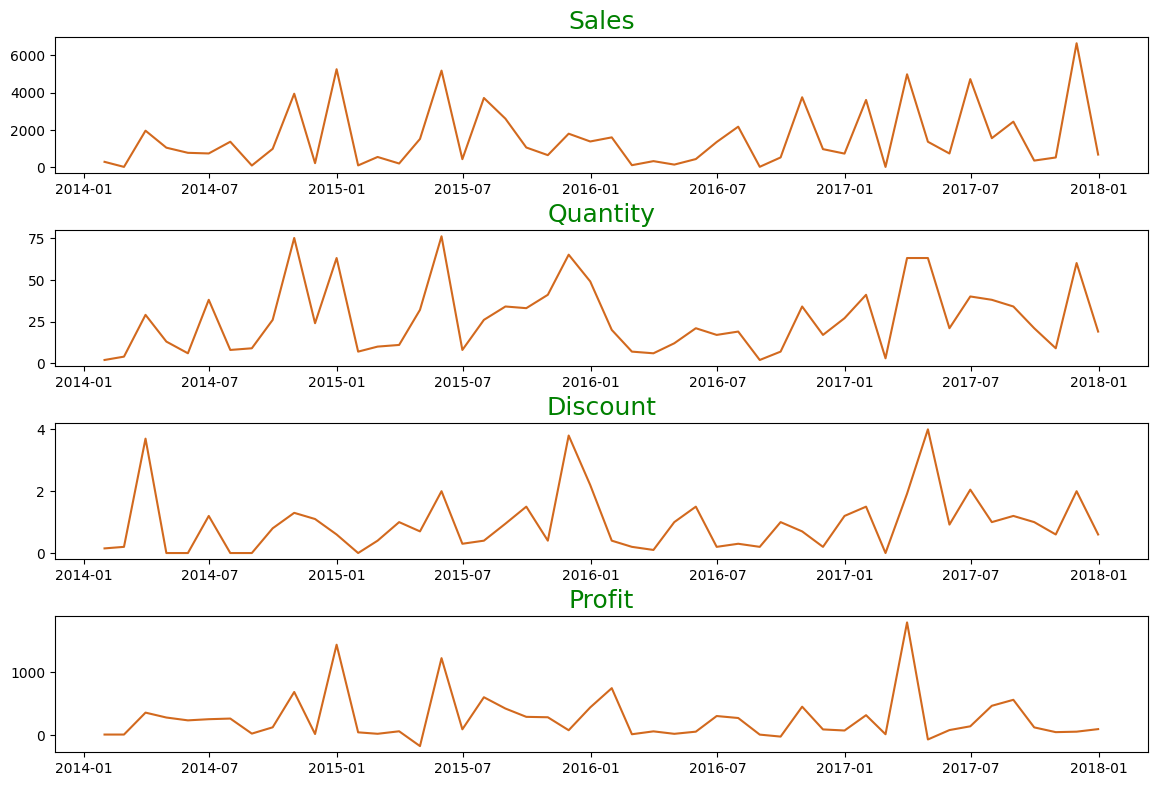

In [61]:
fig, ax = plt.subplots(4,1)
fig.set_size_inches(12,8)
fig.tight_layout(pad=2)
for i, columna in enumerate(ordenes_mensuales.columns):
    ax[i].plot(ordenes_mensuales[columna], color="chocolate")
    ax[i].set_title(columna, color="green", fontsize=18)


Alguno de los meses tenemos un beneficio que podría ser considerado como outlier (el valor máximo de Profit es más de 6 veces la desviación típica con respecto a la media), pero vamos a considerarlo como válido. 

No se aprecia que vayamos a ver tendencias. Ya veremos si hay estacionalidad.

Vemos si hay algunos meses con valor 0 en todas las variables:

In [63]:
for columna in ordenes_mensuales.columns:
    print(f"Meses con valor 0 en la variable {columna}")
    print(ordenes_mensuales.loc[ordenes_mensuales[columna]==0])
    print("----")

Meses con valor 0 en la variable Sales
Empty DataFrame
Columns: [Sales, Quantity, Discount, Profit]
Index: []
----
Meses con valor 0 en la variable Quantity
Empty DataFrame
Columns: [Sales, Quantity, Discount, Profit]
Index: []
----
Meses con valor 0 en la variable Discount
              Sales  Quantity  Discount    Profit
Order Date                                       
2014-04-30  1048.74        13       0.0  276.4956
2014-05-31   773.70         6       0.0  230.9727
2014-07-31  1367.84         8       0.0  259.8896
2014-08-31    92.52         9       0.0   18.5040
2015-01-31    99.26         7       0.0   38.9066
2017-02-28    17.62         3       0.0    8.2242
----
Meses con valor 0 en la variable Profit
Empty DataFrame
Columns: [Sales, Quantity, Discount, Profit]
Index: []
----


Solo hay valores 0 en los descuentos, lo que es perfectamente lógico.

## Análisis

Hay que tener en cuenta que en el dataset completo se almacenan pedidos que pueden tener varias líneas y, por tanto, el Order ID no es único. Y podría haber varios pedidos en un solo día, incluso en la misma ciudad, por lo que la fecha tampoco es única.

Por tanto, ahora mismo tenemos varias series temporales. Querremos analizar las ventas de los supermercados, pero los pasos siguientes dependerán de las preguntas que nos hagamos. Supongamos la siguiente lista:

- ¿Cuál es la ciudad en la que más se vende? ¿Y la más rentable?
- ¿Y el producto más vendido?¿Y el más rentable?
- ¿Hay correlación entre ventas y rentabilidad por ciudades o productos?
- ¿Cuáles son los 10 principales Clientes de la empresa?
- ¿Podemos segmentar a nuestros Clientes?
- ¿Son nuestros Clientes principales repetitivos o solo han hecho un pedido enorme?
- ¿Cual es la repetición y pedido medio de los Clientes repetitivos?

Después elegiremos el producto más rentable y la ciudad más rentable y veremos su evolución temporal para el siguiente paso.

### Transformaciones previas

Igual que para el EDA, vamos a transformar el dataset para ajustarlos a nuestras necesidades. Para el estudio de valores de ventas y beneficio de toda la empresa, nos valdrá con el mismo dataset que para el EDA.

Sin embargo, para el estudio de productos y localizaciones, no nos vale, pues hemos perdido el rastro del Cliente (de donde viene la localización) y del producto. Necesitamos dos agrupaciones distintas: una por Cliente y otra por Producto. Además, lo haremos con dos agregaciones diferentes: suma y cuenta (la suma para tener los valores totales y la cuenta para saber el número de ejemplos agrupados).

In [68]:
ordenes.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Product ID', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [79]:
ordenes_clientes = ordenes \
    .groupby(["Customer ID", "Order Date"]) \
        .aggregate({'Order ID': "count", \
                    'Sales': "sum", \
                    'Quantity': "sum", \
                    'Discount': "sum", \
                    'Profit': "sum" })
ordenes_clientes.head(10)

Order ID     Sales  Quantity  Discount    Profit
Customer ID Order Date                                                  
AA-10315    2014-03-31         2   726.548         4       0.2  267.4224
            2014-09-15         2    29.500         5       0.0   13.2826
            2015-10-04         1    26.960         2       0.0    7.0096
            2016-03-03         4  4406.072        14       0.8 -747.1021
            2017-06-29         2   374.480         5       0.0   96.5050
AA-10375    2014-04-21         1    16.520         5       0.2    5.5755
            2014-10-24         1    34.272         3       0.2   11.1384
            2015-02-03         2   178.370         5       0.0   62.0658
            2015-05-08         1     5.248         2       0.2    0.5904
            2015-11-13         1    84.960         6       0.2    6.3720

In [81]:
ordenes.loc[ordenes["Customer ID"]=="AA-10315"]

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales,Quantity,Discount,Profit
1159,CA-2017-147039,2017-06-29,2017-07-04,Standard Class,AA-10315,OFF-AP-10000576,362.940,3,0.0,90.7350
1160,CA-2017-147039,2017-06-29,2017-07-04,Standard Class,AA-10315,OFF-BI-10004654,11.540,2,0.0,5.7700
1299,CA-2015-121391,2015-10-04,2015-10-07,First Class,AA-10315,OFF-ST-10001590,26.960,2,0.0,7.0096
2229,CA-2014-128055,2014-03-31,2014-04-05,Standard Class,AA-10315,OFF-BI-10004390,673.568,2,0.2,252.5880
2230,CA-2014-128055,2014-03-31,2014-04-05,Standard Class,AA-10315,OFF-AP-10002765,52.980,2,0.0,14.8344
5198,CA-2016-103982,2016-03-03,2016-03-08,Standard Class,AA-10315,OFF-SU-10000151,3930.072,3,0.2,-786.0144
5199,CA-2016-103982,2016-03-03,2016-03-08,Standard Class,AA-10315,OFF-FA-10001332,2.304,1,0.2,0.7776
5200,CA-2016-103982,2016-03-03,2016-03-08,Standard Class,AA-10315,TEC-PH-10000895,431.976,3,0.2,32.3982
5201,CA-2016-103982,2016-03-03,2016-03-08,Standard Class,AA-10315,TEC-AC-10002857,41.720,7,0.2,5.7365
7468,CA-2014-138100,2014-09-15,2014-09-20,Standard Class,AA-10315,OFF-PA-10000349,14.940,3,0.0,7.0218


### Análisis de toda la empresa

<Axes: xlabel='Order Date'>

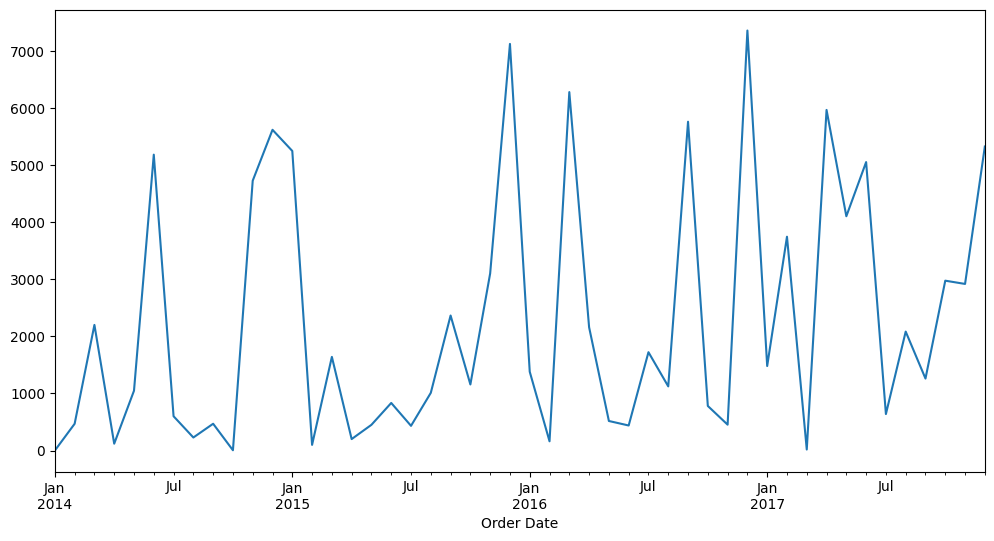

In [45]:
ordenes_mensuales["Sales"].plot(figsize=[12,6])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 978 entries, 2014-01-03 to 2017-12-27
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sales     978 non-null    float64
 1   Quantity  978 non-null    int64  
 2   Discount  978 non-null    float64
 3   Profit    978 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 38.2 KB
